In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import cv2
from scipy.io import loadmat
from PIL import Image

In [8]:
# =========================================================================================================================
# This is a helper to the preprocess_mat_to_csv function. 
#
# This function takes as input the raw dictionary generated by loading the MATLAB file with scipy.io.loadmat, and returns
# a dictionary that maps each target class to the associated car name.
# ==========================================================================================================================
def make_class_to_num_map(mat):
    
    class_names = mat['class_names'][0]
    
    num_to_class_map = {index : class_name[0] for index, class_name in enumerate(class_names, start=1)}
    
    return num_to_class_map

In [9]:
# ==========================================================================================================================
# When scipy.io.loadmat converts the MATLAB file to a python dictionary, the formatting is not intuitive.
# 
# As a result, a significant amount of data exploration was required to be able to prove to myself what each
# feature in the original MATLAB file actually represented. 
#
# By analyzing the values and using process of elmination I am confident that the features are correctly labeled,
# however the work that was performed to get to this understand is not shown here. So if this function seems
# a bit mysterious, that is understandable. You can take my word for it that these are the correct values, or if
# desired it is possible to prove based on the values in each column and process of elmination what they have to be.
# ==========================================================================================================================
def make_annotations_dict(mat):
    
    annotations_dict = {"filename" : [file[0][0].split("/")[1] for index, file in enumerate(mat['annotations'][0])],
                        "min_x" : [file[1][0][0] for index, file in enumerate(mat['annotations'][0])],
                        "min_y" : [file[2][0][0] for index, file in enumerate(mat['annotations'][0])],
                        "max_x" : [file[3][0][0] for index, file in enumerate(mat['annotations'][0])],
                        "max_y" : [file[4][0][0] for index, file in enumerate(mat['annotations'][0])],
                        "target" : [file[5][0][0] for index, file in enumerate(mat['annotations'][0])],
                        "train_or_test" : [file[6][0][0] for index, file in enumerate(mat['annotations'][0])]}    
    
    return annotations_dict


In [10]:
# ==========================================================================================================================
# The Stanford Cars dataset is provided as a MATLAB file. 
#
# This function uses scipy to read in the MATLAB file as a python dictionary, and then parses the file into a suitable
# format to load into a pandas dataframe and then save as a .csv.
#
# After this function has been run, the Stanford Cars data that contains information to cross reference each image file 
# with the correct target class and car name will be available in a convenient .csv which we will reference for the
# remainder of the project. 
# ==========================================================================================================================
def preprocess_mat_to_csv(mat_file_path = "./data/cars_annos.mat", csv_save_path="./data/labeled_car_data.csv"):
    
    # Use scipy to load the MATLAB file into a python dictionary.
    mat = loadmat(mat_file_path)
    
    # Parse the dictionary created above into a format more condusive to saving as a .csv file. 
    annotations_dict = make_annotations_dict(mat)

    # Create a map that converts the target class to the associated car name.
    class_num_to_car_name_map = make_class_to_num_map(mat)
    
    # Create a list that contains the car name for each sample in the dataset
    car_names = [class_num_to_car_name_map[num] for num in annotations_dict['target']]
    
    # Add the car name as a new key in our car dataset dictionary
    annotations_dict['car_names'] = car_names
    
    # Save the organized car datset to a pandas dataframe.
    df = pd.DataFrame(annotations_dict)
    
    # Save the dataset to .csv
    df.to_csv(csv_save_path, index=False)
    
    return df

In [11]:
# Read in the MATLAB file for Stanford Cars, parse, and save to .csv
car_df = preprocess_mat_to_csv()

In [14]:
car_df.head()

,filename,min_x,min_y,max_x,max_y,target,train_or_test,car_names
0,000001.jpg,112,7,853,717,1,0,AM General Hummer SUV 2000
1,000002.jpg,48,24,441,202,1,0,AM General Hummer SUV 2000
2,000003.jpg,7,4,277,180,1,0,AM General Hummer SUV 2000
3,000004.jpg,33,50,197,150,1,0,AM General Hummer SUV 2000
4,000005.jpg,5,8,83,58,1,0,AM General Hummer SUV 2000


In [15]:
# ==========================================================================================================================
# This uses dataframe output by the preprocess_mat_to_csv function to display images from any of the 196 classes
# in the Stanford cars dataset.
#
# This function was used for some initial exploration, to get some familiarity with the images in the dataset.
# ==========================================================================================================================
def plot_image_from_class(car_df, class_num, num_images = 5):
    
    df = car_df.loc[car_df['target'] == class_num, :].copy()

    df.reset_index(drop=True, inplace=True)

    filenames = list(df.loc[(df.index <= num_images - 1), 'filename'].to_numpy())
    
    car_name = list(df.loc[(df.index <= num_images - 1), 'car_names'].to_numpy())[0]
    
    file_paths = [os.path.join("./data/car_ims/", filename) for filename in filenames]
    
    image_arrs = [cv2.imread(path) for path in file_paths]
    
    fig, axs = plt.subplots(nrows=1, ncols=num_images, figsize=(num_images * 5, 10), squeeze=False)
    
    for index, img_arr in enumerate(image_arrs):
        
        axs[0][index].imshow(img_arr)
        
        axs[0][index].set_title(f"Class: {class_num}\nName: {car_name}\n File: {filenames[index]}", weight='bold')
    

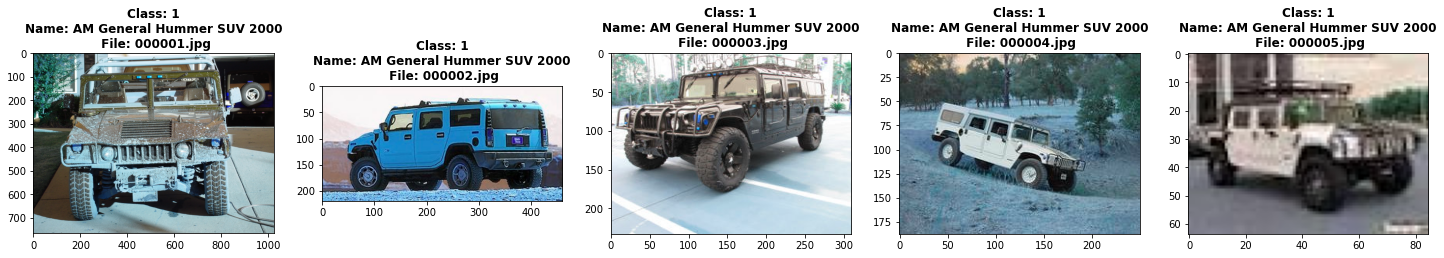

In [16]:
plot_image_from_class(car_df, class_num=1, num_images = 5)

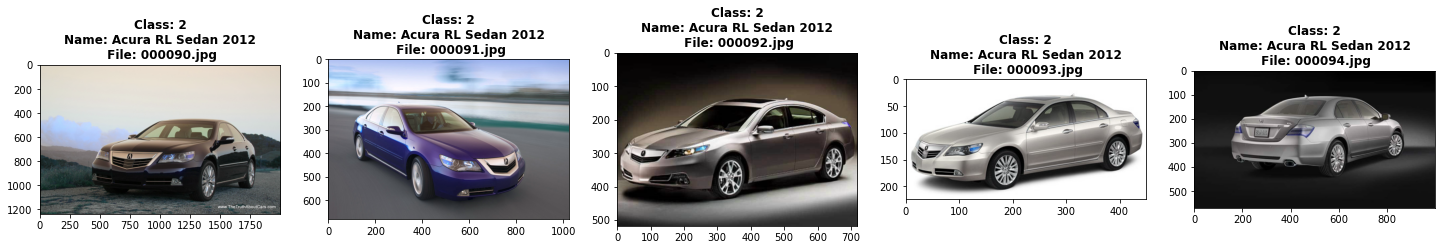

In [17]:
plot_image_from_class(car_df, class_num=2, num_images = 5)

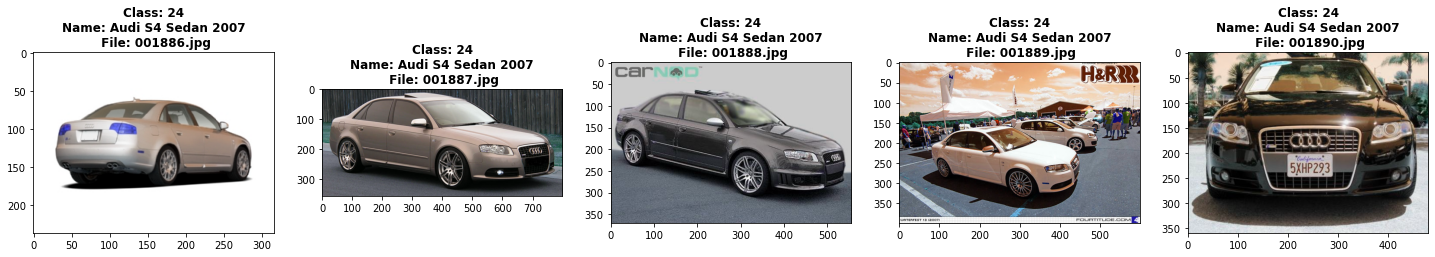

In [18]:
plot_image_from_class(car_df, class_num=24, num_images = 5)

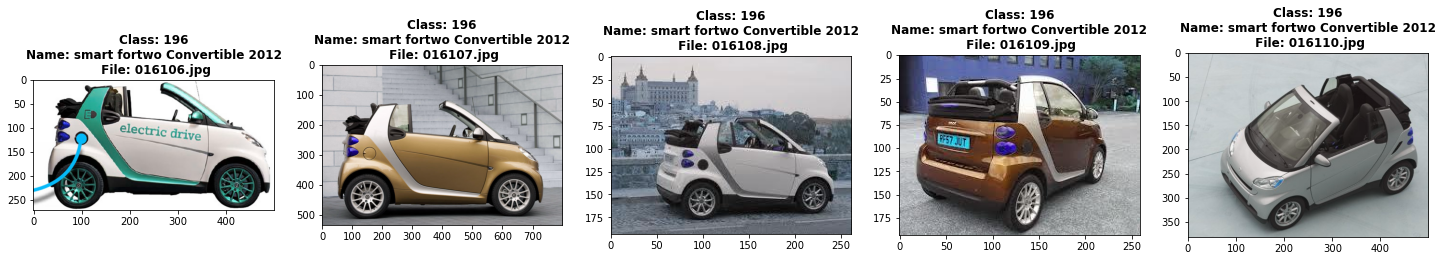

In [19]:
plot_image_from_class(car_df, class_num=196, num_images = 5)

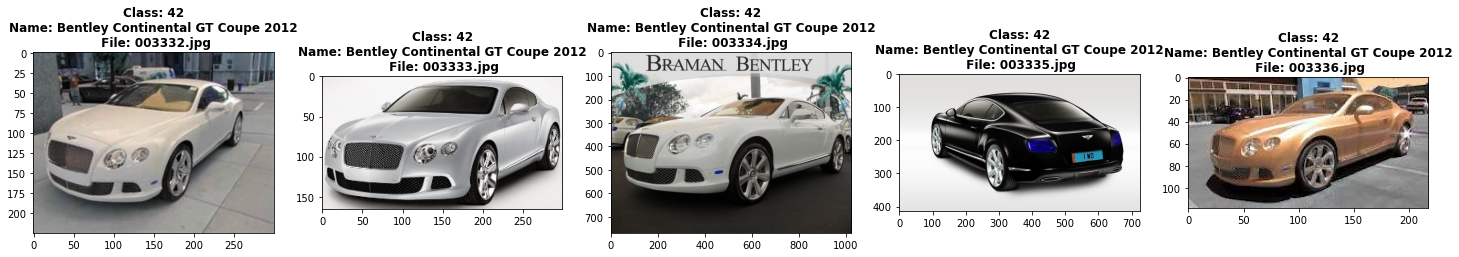

In [13]:
plot_image_from_class(car_df, class_num=42, num_images = 5)

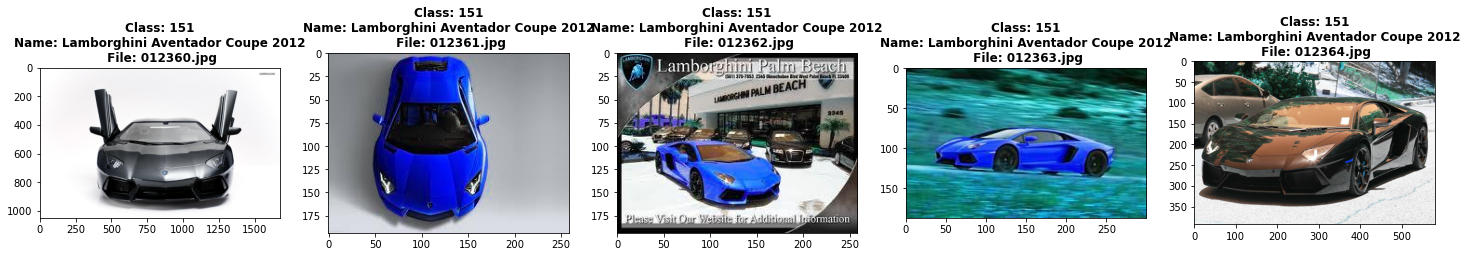

In [15]:
plot_image_from_class(car_df, class_num=151, num_images = 5)

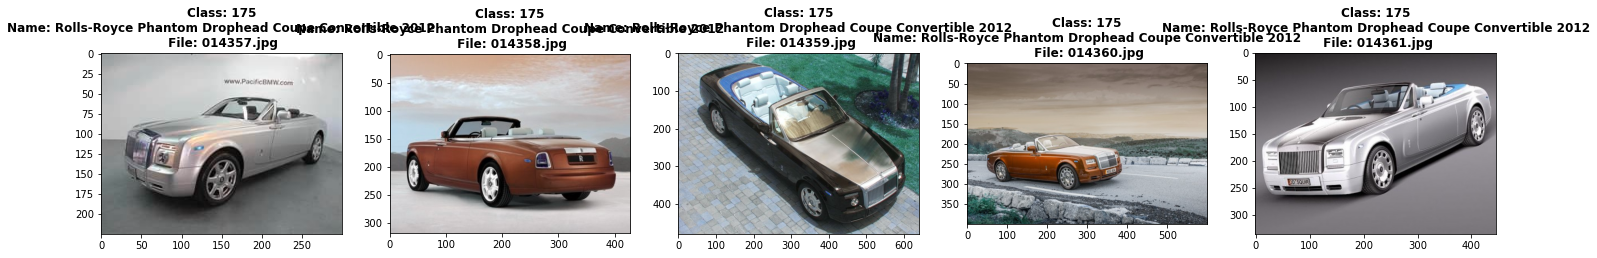

In [20]:
plot_image_from_class(car_df, class_num=175, num_images = 5)

In [17]:
# ==================================================================================================================
# This function takes in the filename of an image, and returns the images height and width in pixels.
#
# This is a helper function to the get_image_height_and_width_stats function below.
# ==================================================================================================================
def get_image_shape(im_name):
    
    pil_image = Image.open(f'./data/car_ims/{im_name}.jpg')
    
    width, height = pil_image.size
    
    return width, height

In [20]:
# ==================================================================================================================
# Prior to modeling, all images will be resized to some constant dimensions. In order to make an informed decision
# regarding what a reasonable size to resize each image to is, this function was used to calculate the average
# and median dimensions for the images in the dataset.
# ==================================================================================================================
def get_image_height_and_width_stats(df):
    
    image_names = [file.split(".")[0] for file in os.listdir("./data/car_ims/")]
    
    num_images = len(image_names)
    widths = []
    heights = []
    
    for image_name in image_names: 
        width, height = get_image_shape(image_name)
        
        widths.append(width)
        heights.append(height)
    
    mean_w = np.mean(widths)
    mean_h = np.mean(heights)
    
    print("================================================")
    print(f"Average Width: {np.mean(widths)}")
    print(f"Average Height: {np.mean(heights)}")
    print(f"Median Width: {np.median(widths)}")
    print(f"Median Height: {np.median(heights)}")
    print("================================================")
    
    return mean_w, mean_h 
    

In [21]:
avg_width, avg_height = get_image_height_and_width_stats(car_df)

Average Width: 700.4925548347235
Average Height: 483.2458449181341
Median Width: 640.0
Median Height: 426.0
